In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [3]:
import spatialdata_io

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [4]:
sdata = spatialdata_io.xenium('/home/mffang/data/counts/10x/mouse_brain_xenium_2024')
sdata

INFO     reading /home/mffang/data/counts/10x/mouse_brain_xenium_2024/cell_feature_matrix.h5                       


/tmp/ipykernel_215357/3310779193.py:1: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  sdata = spatialdata_io.xenium('/home/mffang/data/counts/10x/mouse_brain_xenium_2024')


SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 23912, 34154), (5, 11956, 17077), (5, 5978, 8538), (5, 2989, 4269), (5, 1494, 2134)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (23912, 34154), (11956, 17077), (5978, 8538), (2989, 4269), (1494, 2134)
│     └── 'nucleus_labels': DataTree[yx] (23912, 34154), (11956, 17077), (5978, 8538), (2989, 4269), (1494, 2134)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (63173, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (63173, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (63036, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (63173, 5006)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)

In [5]:
adata = sdata.tables['table']
adata.obs

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level,cell_labels
0,aaaalabd-1,2193,1,0,0,3,2,2199,49.626721,33.099532,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,1
1,aaabcnhh-1,1873,0,0,0,0,0,1873,55.226096,38.427970,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,2
2,aaacnmip-1,2163,0,0,1,1,0,2165,85.796878,75.456096,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,3
3,aaadikih-1,2441,0,0,0,4,1,2446,94.060472,52.290939,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,4
4,aaaeinek-1,1407,0,0,0,0,0,1407,112.258442,NaN,0.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63168,oildnokf-1,112,0,0,0,0,0,112,39.240783,12.643750,1.0,Segmented by nucleus expansion of 5.0µm,cell_circles,4.0,63169
63169,oildpboo-1,663,0,0,0,0,0,663,135.017192,10.702032,1.0,Segmented by nucleus expansion of 5.0µm,cell_circles,4.0,63170
63170,oilgaepb-1,320,0,0,0,0,0,320,138.449068,12.417969,1.0,Segmented by nucleus expansion of 5.0µm,cell_circles,4.0,63171
63171,oilgmbbn-1,299,0,0,0,1,0,300,116.683754,11.785782,1.0,Segmented by nucleus expansion of 5.0µm,cell_circles,5.0,63172


In [6]:
adata.obs['segmentation_method'] = adata.obs['segmentation_method'].astype(str)
idx = adata.obs['segmentation_method'] != 'Segmented by nucleus expansion of 5.0µm'
adata = adata[idx]  # Use boolean indexing directly
adata

View of AnnData object with n_obs × n_vars = 59923 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

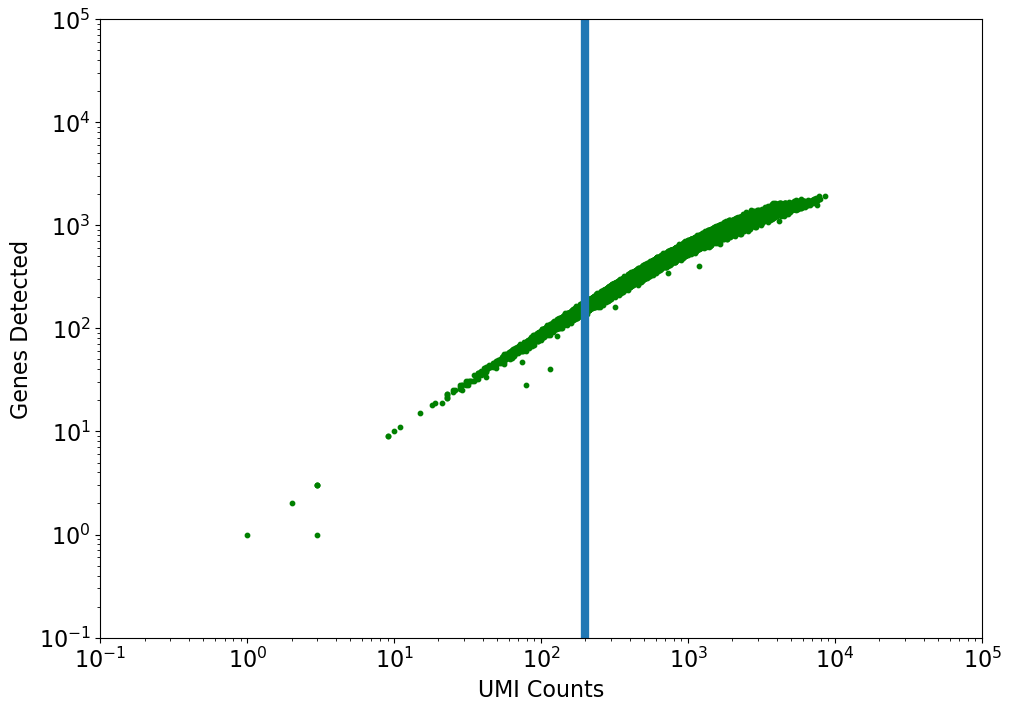

In [7]:
mtx = adata.X

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=10, alpha=1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e-1,1e5))
ax.set_ylim((1e-1,1e5))
ax.axvline(x=200)

plt.show()

In [8]:
import statistics

statistics.median(mtx.sum(axis=1))

matrix([[1137.]], dtype=float32)

In [9]:
adata.obs_names = adata.obs_names.astype(str)  # Convert index to string
idx = mtx.sum(axis=1) >= 10
adata = adata[idx]
adata

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


View of AnnData object with n_obs × n_vars = 59904 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

R² = 0.83
Pearson correlation = 0.94
CCC = 0.93
MSE = 0.0647
RMSE = 0.2543


(0.39154586474752223, 0.52106017)

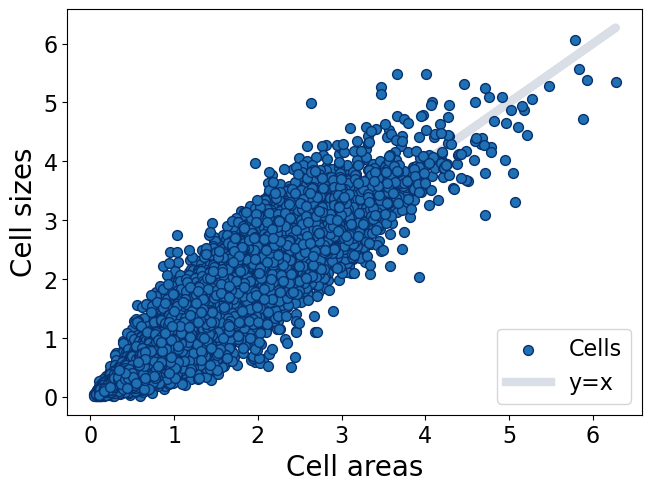

In [10]:
x = adata.obs['cell_area'] #- adata.obs['nucleus_area']

y = adata.X.toarray().sum(1)
x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,color='#2070b4',edgecolor='#08326e',s=50,alpha=1,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

# Compute R² only if enough valid points exist
if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')

x.var(),y.var()

# Calculate CV$^2$ of read depth

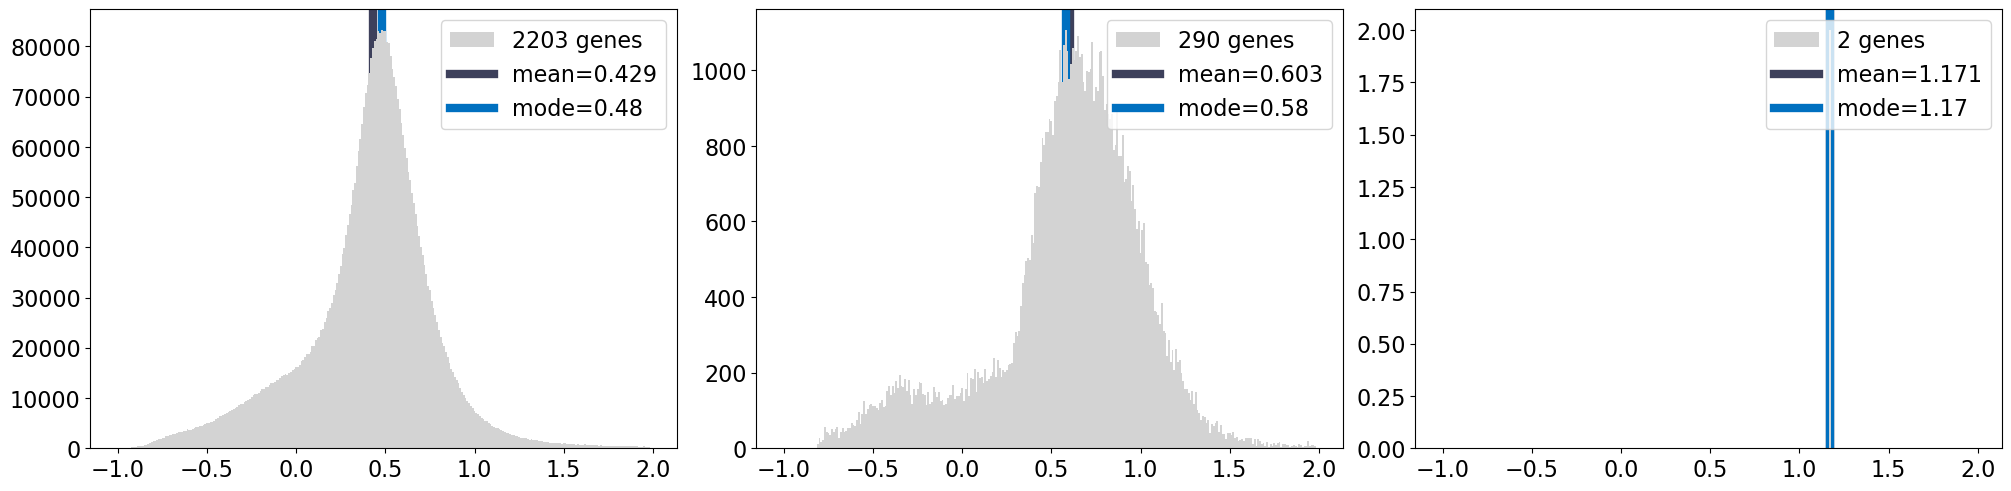

In [31]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.X.toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(-1,2,0.01)-0.005)
s = estimate_s(N1=adata.X.toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(-1,2,0.01)-0.005)
s = estimate_s(N1=adata.X.toarray(),ax=axs[2],min_mean=10,bins=np.arange(-1,2,0.01)-0.005)

Text(0.5, 0, 'Values')

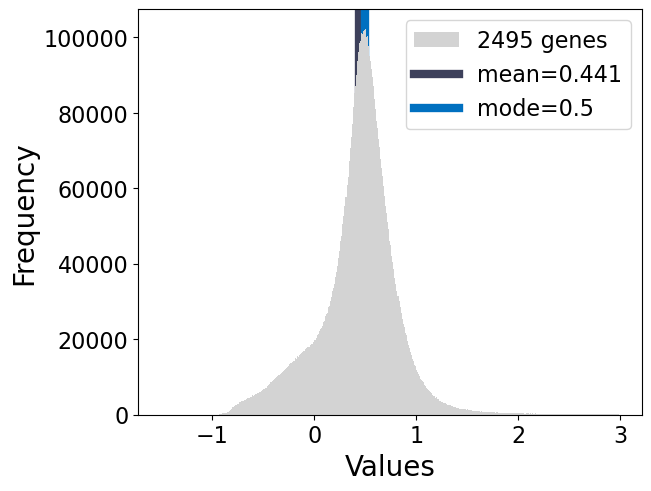

In [32]:
fig,axs = plt.subplots(1,1)

_ = estimate_s(N1=adata.X.toarray(),ax=axs,min_mean=0.1,bins=np.arange(-1.5,3,0.01)-0.005)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

# Variance plots

In [33]:
X_ = adata.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=50,alpha=0.05)

Text(0.5, 0, 'Values')

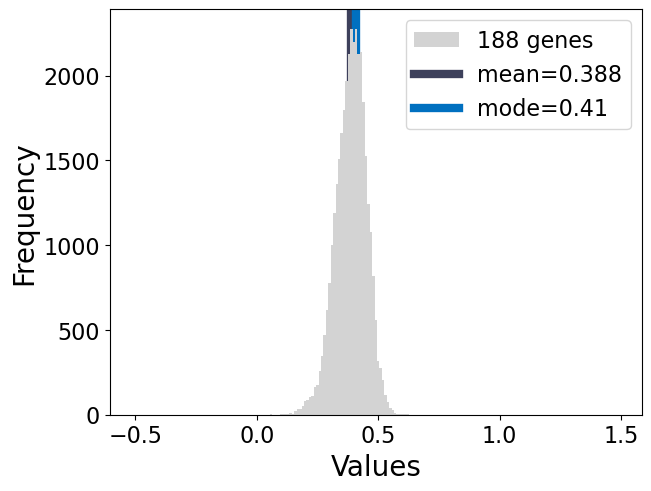

In [34]:
s = 0.5

Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene = adata.var_names[nonzero_idx][Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(Pgene)
X_ = adata.X.toarray()[:,idx]
_ = estimate_s(X_,ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

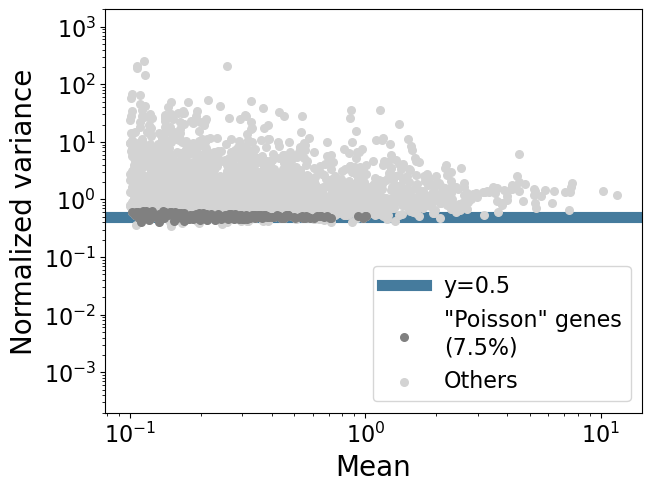

In [35]:
X_ = adata.X.toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [36]:
# Save to text file (each string will be on a new line)
np.savetxt("results/mouse_xenium_Pgenes.txt", np.array(Pgene), fmt='%s')

R² = 0.8299999833106995
Pearson correlation = 0.93
CCC = 0.92
MSE = 0.0706000030040741
RMSE = 0.26570001244544983


(np.float32(0.40818906), np.float32(0.52106017))

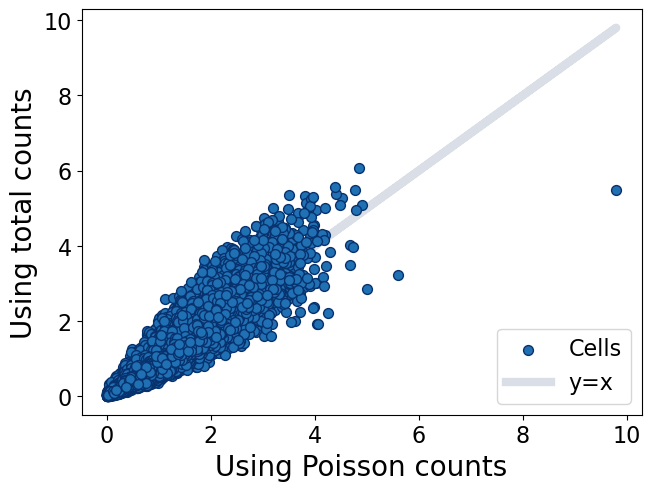

In [37]:
X_ = adata.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,Pgene_mask].sum(1)
cellsize_S = cellsize_S/cellsize_S.mean()

cellsize_X = adata.X.toarray().copy().sum(1)
cellsize_X = cellsize_X/cellsize_X.mean()

x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(cellsize_S,cellsize_X,color='#2070b4',edgecolor='#08326e',s=50,alpha=1,label='Cells')
ax.plot(cellsize_S,cellsize_S,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using Poisson counts',fontsize=20)
plt.ylabel('Using total counts',fontsize=20)

# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')

cellsize_S.var(),cellsize_X.var()

R² = 0.78
Pearson correlation = 0.90
CCC = 0.90
MSE = 0.0859
RMSE = 0.2931


(np.float32(0.40818906), np.float32(0.52106017))

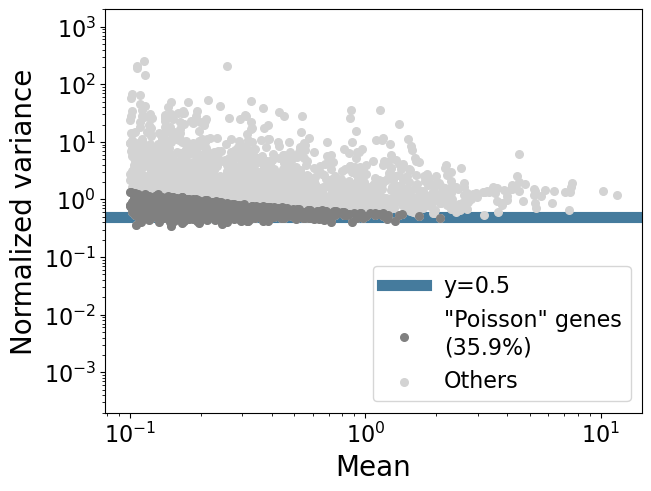

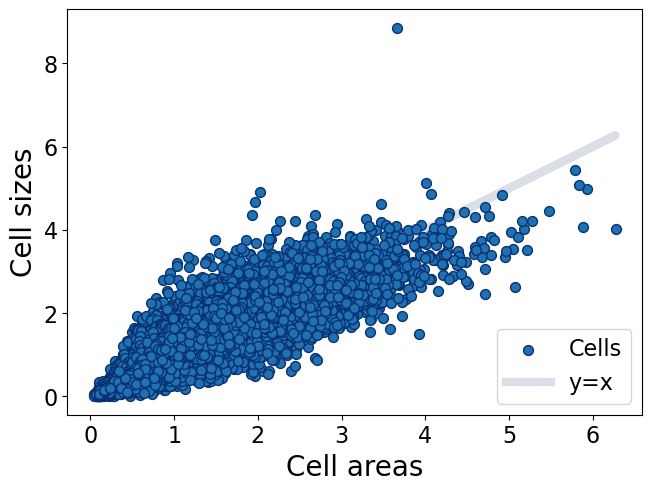

In [38]:
x = adata.obs['cell_area'] #- adata.obs['nucleus_area']

Pgene_mask = ((X_var - X_mean)/X_mean**2 - s)*X_mean < 0.1
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

X_ = adata.X.toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
y = X_[:,Pgene_mask].sum(1)
x = x/x.mean()
y = y/y.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(x,y,color='#2070b4',edgecolor='#08326e',s=50,alpha=1,label='Cells')
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Cell areas',fontsize=20)
plt.ylabel('Cell sizes',fontsize=20)


# Clean invalid values
mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
x_clean = x[mask]
y_clean = y[mask]

# Compute R² only if enough valid points exist
if len(x_clean) > 1 and len(y_clean) > 1:
    ss_total = np.sum((x_clean - np.mean(x_clean)) ** 2)
    ss_residual = np.sum((y_clean - x_clean) ** 2)
    r2 = 1 - (ss_residual / ss_total) 
    print(f'R² = {np.around(r2, 2)}')
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    print(f'Pearson correlation = {r:.2f}')
    ccc = CCC(x_clean, y_clean)
    print(f'CCC = {ccc:.2f}')
    mse = np.mean((y_clean - x_clean) ** 2)
    print(f'MSE = {np.around(mse, 4)}')
    rmse = np.sqrt(mse)
    print(f'RMSE = {np.around(rmse, 4)}')

cellsize_S.var(),cellsize_X.var()